In [1]:
#importar librerias
import simpeg
import gempy as gp
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc, active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps
from simpeg.potential_fields import gravity
from skimage.transform import resize
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
write_output = False
import pickle
import pyvista as pv

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


C:\Users\luisa\.conda\envs\gempy\lib\site-packages\numpy\distutils\system_info.py:2159: UserWarning: 
    Optimized (vendor) Blas libraries are not found.
    Falls back to netlib Blas library which has worse performance.
    A better performance should be easily gained by switching
    Blas library.
  if self._calc_info(blas):
C:\Users\luisa\.conda\envs\gempy\lib\site-packages\numpy\distutils\system_info.py:2159: UserWarning: 
    Blas (http://www.netlib.org/blas/) libraries not found.
    Directories to search for the libraries can be specified in the
    numpy/distutils/site.cfg file (section [blas]) or by setting
    the BLAS environment variable.
  if self._calc_info(blas):
C:\Users\luisa\.conda\envs\gempy\lib\site-packages\numpy\distutils\system_info.py:2159: UserWarning: 
    Blas (http://www.netlib.org/blas/) sources not found.
    Directories to search for the sources can be specified in the
    numpy/distutils/site.cfg file (section [blas_src]) or by setting
    the BLAS_SRC 

In [3]:
#importar modelo de gempy
geo_model = pickle.load(open("geo_model_sinescala.p", "rb"))

In [4]:
#Creación del Tensor Mesh a partir del modelo de gempy
xminmax = np.min(geo_model.grid.values[:, 0]), np.max(geo_model.grid.values[:, 0])
yminmax = np.min(geo_model.grid.values[:, 1]), np.max(geo_model.grid.values[:, 1])
zminmax = np.min(geo_model.grid.values[:, 2]), np.max(geo_model.grid.values[:, 2])

xminmax, yminmax, zminmax

((1116740.0, 1263260.0), (984330.0, 1049670.0), (-795.0, 195.0))

In [5]:
nx, ny, nz = 100, 100, 100

In [6]:
dx = np.diff(xminmax)/nx
dy = np.diff(yminmax)/ny
dz = np.diff(zminmax)/nz

dx, dy, dz

(array([1465.2]), array([653.4]), array([9.9]))

In [7]:
# Tensor Mesh
grid = TensorMesh(
    [
        [(dx, nx)],
        [(dy, ny)],
        [(dz, nz)]
    ],
    x0=['C', 'C', zminmax[0]]
)
grid.x0 += [np.mean(xminmax), np.mean(yminmax), 0]
grid

TensorMesh: 1,000,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    100  1,116,740.00  1,263,260.00  1,465.20  1,465.20    1.00
   y    100    984,330.00  1,049,670.00    653.40    653.40    1.00
   z    100       -795.00        195.00      9.90      9.90    1.00

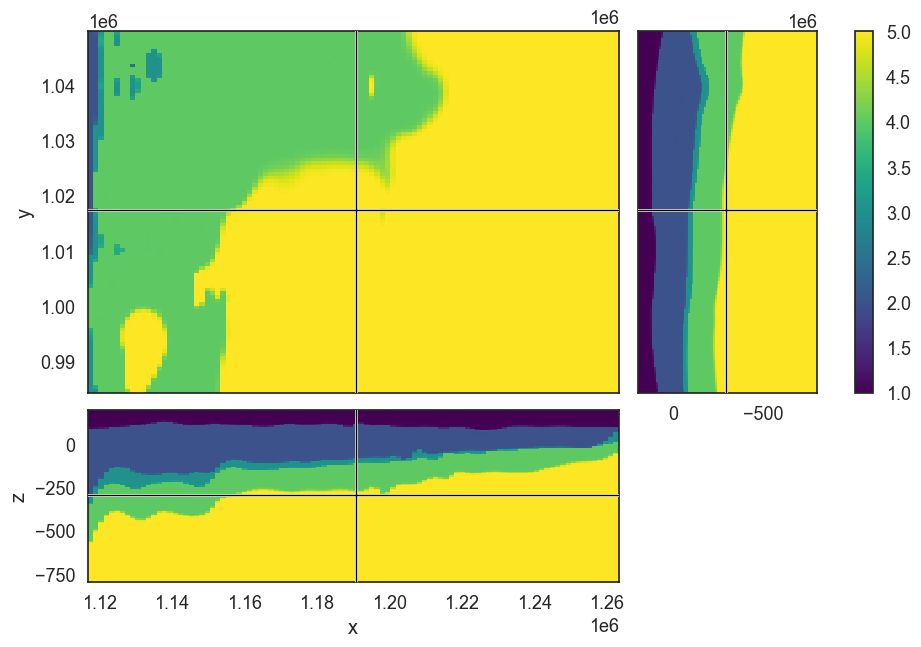

In [20]:
#visualización del modelo de litologías
vals = geo_model.solutions.lith_block.reshape(grid.vnC, order='C').ravel('F')
grid.plot_3d_slicer(vals, pcolorOpts={'cmap': 'viridis'})

In [8]:
#redimensionar el Tensor Mesh si es necesario
nx1 = 80  # Número de celdas en X
ny1 = 80  # Número de celdas en Y
nz1 = 80  # Número de celdas en Z (aumentamos en Z)

# Crear la malla
grid = TensorMesh(
    
    
    [
        [(3000, nx1)],  # Dirección X
        [(1500, ny1)],  # Dirección Y
        [(12.5, nz1)]   # Dirección Z 
    ],
    x0='CCC'  # Coordenadas iniciales
)

# Posición de la malla
grid.x0 += [np.mean([xminmax[0], xminmax[1]]), np.mean([yminmax[0], yminmax[1]]),np.mean([zminmax[0], zminmax[1]])]

print(grid)


  TensorMesh: 512,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     80  1,070,000.00  1,310,000.00  3,000.00  3,000.00    1.00
   y     80    957,000.00  1,077,000.00  1,500.00  1,500.00    1.00
   z     80       -800.00        200.00     12.50     12.50    1.00




In [8]:
#Computar Tensor Mesh y el modelo geológico
sol = gp.compute_model_at(grid.gridCC, geo_model)

Active grids: ['custom']


In [9]:
#consulta de id de las capas para integrar propiedades
geo_model.surfaces

,surface,series,order_surfaces,color,id
3,Depósitos del Cuaternario,Strat_Series1,1,#728f02,1
1,Formación Guayabo,Strat_Series2,1,#9f0052,2
2,Formación León,Strat_Series3,1,#ffbe00,3
0,Formación Carbonera,Strat_Series4,1,#015482,4
4,Granito de Parguaza,Strat_Series5,1,#443988,5


In [10]:
#creación del modelo de contraste de densidades
den2 = sol[0][0, :grid.nC]
den2[np.round(den2) == 1] = 0.8 
den2[np.round(den2) == 2] = 0.6  
den2[np.round(den2) == 3] = 0.5  
den2[np.round(den2) == 4] = 0.4  
den2[np.round(den2) == 5] = 0 


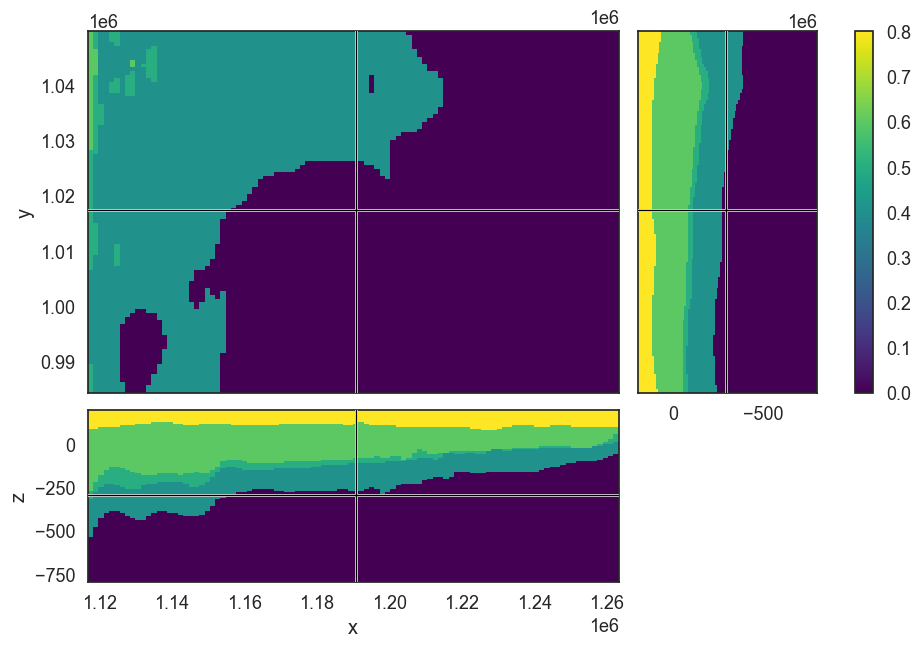

In [11]:
grid.plot_3d_slicer(den2, pcolorOpts={'cmap': 'viridis'})

In [12]:
#Topografía
import rasterio
from rasterio.plot import show

with rasterio.open('DEM2.tif') as src:
    dem_data = src.read(1)  


transform = src.transform
rows, cols = dem_data.shape
x_topo, y_topo = np.meshgrid(np.arange(cols), np.arange(rows))


x_topo, y_topo = rasterio.transform.xy(transform, y_topo, x_topo)


x_topo = mkvc(x_topo)
y_topo = mkvc(y_topo)
z_topo = mkvc(dem_data.flatten())


xyz_topo = np.c_[x_topo, y_topo, z_topo]

In [13]:
#Creación del survey
x = np.linspace(1117240.0, 1262760.0, 50)
y = np.linspace(984830.0, 1049170.0, 50)


x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10  
receiver_locations = np.c_[x, y, z]

components = ["gz"]

receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Definir el survey
survey = gravity.survey.Survey(source_field)

In [14]:
ind_active = active_from_xyz(grid, xyz_topo)

nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)
model = den2[ind_active]


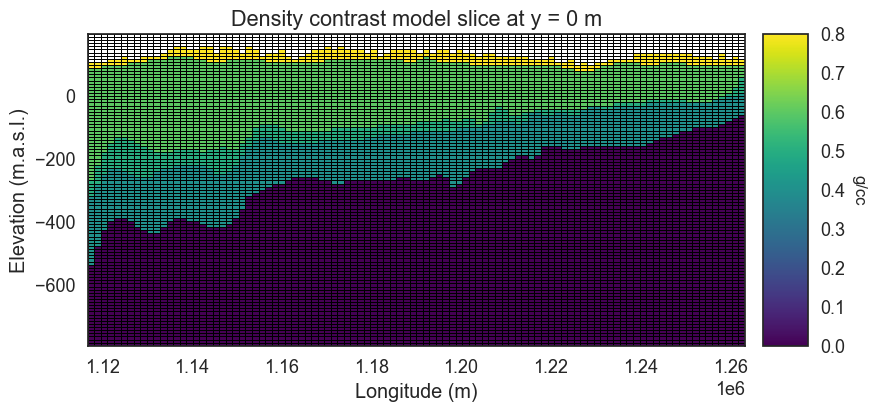

In [15]:
#plotear modelo de densidades/contrastes
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(grid, ind_active,np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
grid.plot_slice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(grid.shape_cells[1] / 2),
    grid=True,
    pcolor_opts = {"cmap":"viridis"},
)
ax1.set_title("Density contrast model slice at y = 0 m")
ax1.set_xlabel("Longitude (m)")
ax1.set_ylabel("Elevation (m.a.s.l.)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, cmap='viridis', orientation="vertical")
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

plt.show()

In [16]:
#simulación 3D 
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=grid,
    rhoMap=model_map,
    active_cells=ind_active,
    store_sensitivities="forward_only",
    engine="choclo",
)

In [17]:
dpred = simulation.dpred(model)

In [18]:
dpred_corregido = dpred * -1

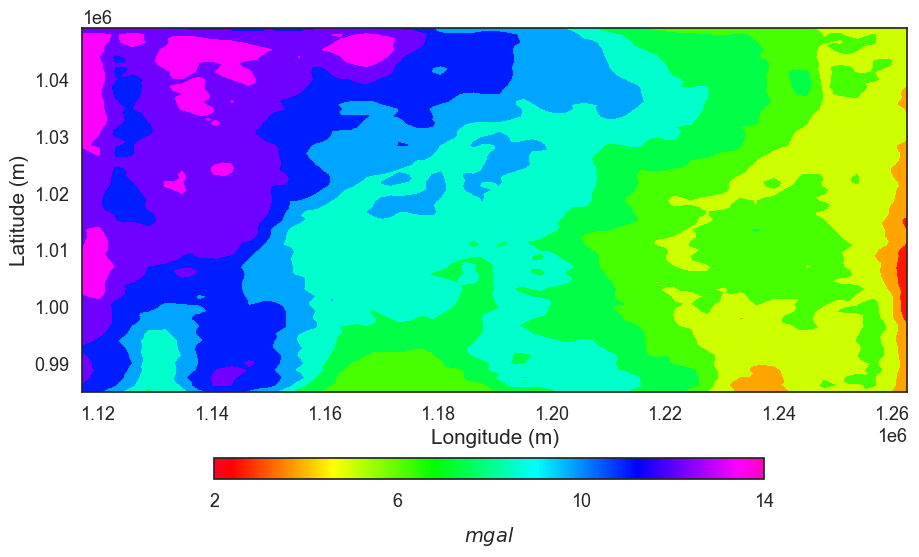

In [19]:
# Plotear modelo de gravimetria
fig = plt.figure(figsize=(11, 7))

v_max = np.max(dpred_corregido)
v_min = np.min(dpred_corregido)

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(
    receiver_list[0].locations,
    dpred_corregido,
    clim=(v_min, v_max),
    ax=ax1,
    contourOpts={"cmap": "gist_rainbow"}
)
ax1.set_title("")
ax1.set_xlabel("Longitude (m)", fontsize=15)
ax1.set_ylabel("Latitude (m)", fontsize=15)
plt.yticks(fontsize=13)  # Cambiar tamaño de las marcas del eje y
plt.xticks(fontsize=13)
ax2 = fig.add_axes([0.22, 0.14, 0.5, 0.03]) 
#norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
# Normalización de los datos para la colorbar
norm = mpl.colors.Normalize(v_min, v_max)
ticks = np.linspace(v_min, v_max, 4)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal", cmap=mpl.cm.gist_rainbow, format="%.0f", ticks=ticks
)
cbar.set_label("$mgal$", rotation=0, labelpad=10, size=14)
#plt.savefig('gravimetric3.svg')
plt.show()